# **Assignment 2 For Clustering Data Analytics**
<hr>

**Submitted by:** Jude M. Ando & Niles Vincent Gabrielle Rondez <br>
**Course & Year:** BSCS - 2 <br>
**Schedule:** M W 10:30 AM - 12:00 PM <br>
<hr>

## Introduction
This notebook implements the Sessa Empirical Estimator for medication adherence analysis. It uses K-Means and DBSCAN clustering algorithms to analyze simulated patient data.

## Convert SEE.R Codes into Python Codes

In [ ]:
## Ibutang imo code sa pagcovert pls judey

## Sessa Empirical Estimator

=== Clustering Results for medA ===


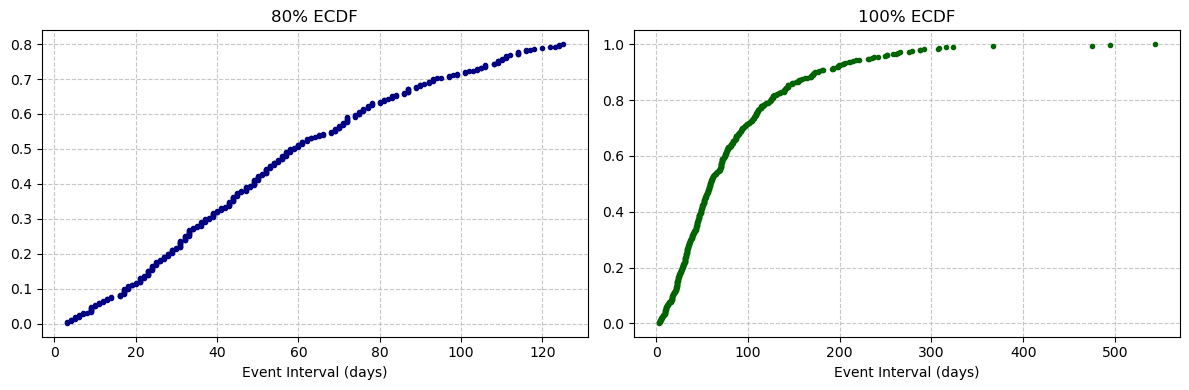

C:\Users\Niles Rondez\AppData\Local\Temp\ipykernel_17612\3643743130.py:65: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.log(dfper['x']), shade=True, color='purple')


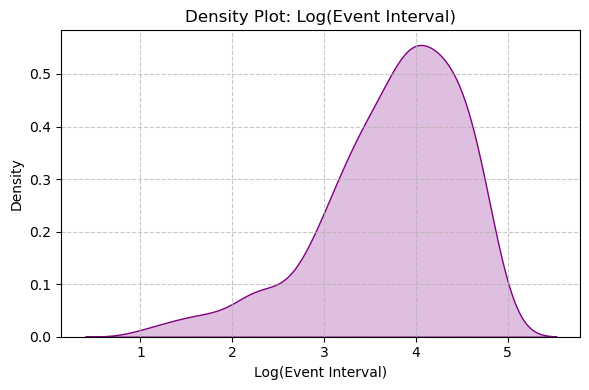

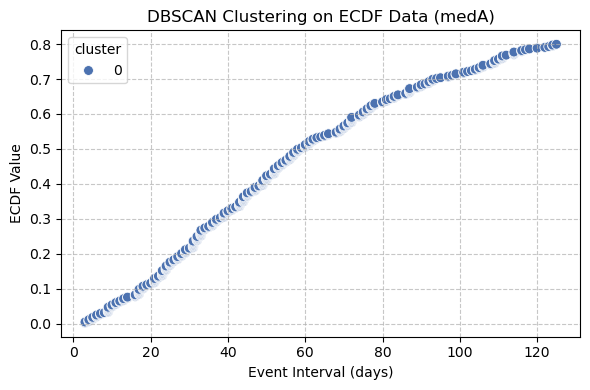

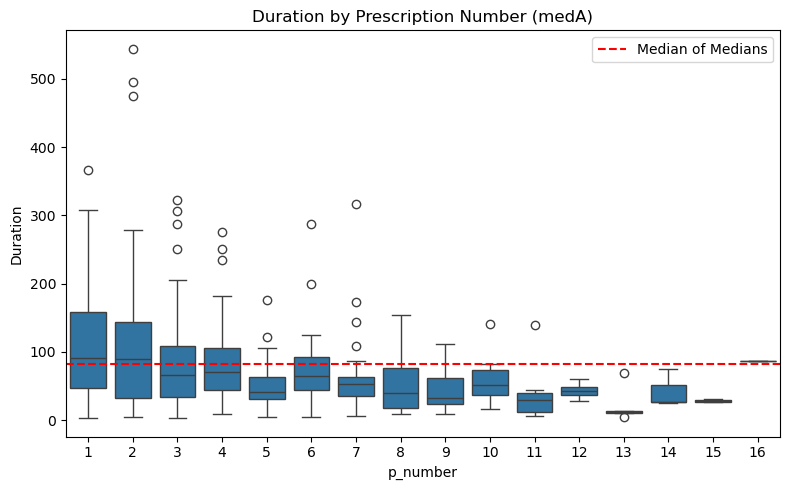

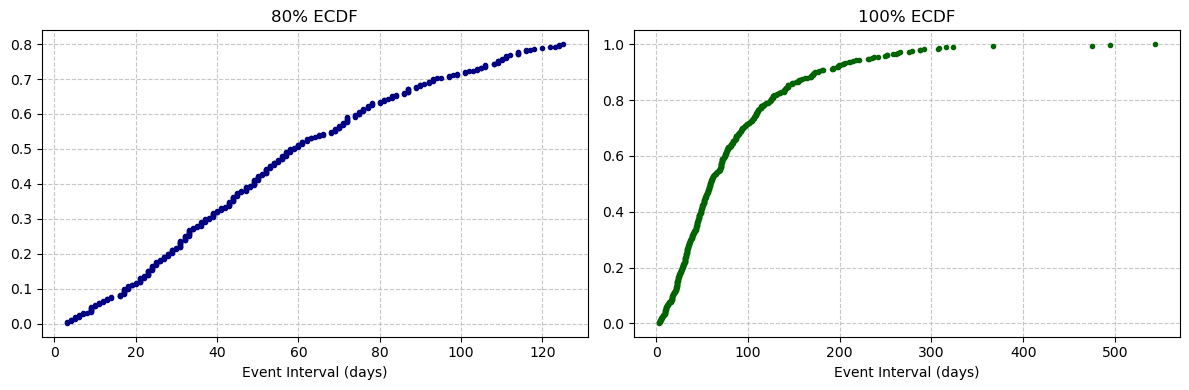

C:\Users\Niles Rondez\AppData\Local\Temp\ipykernel_17612\3643743130.py:65: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.log(dfper['x']), shade=True, color='purple')


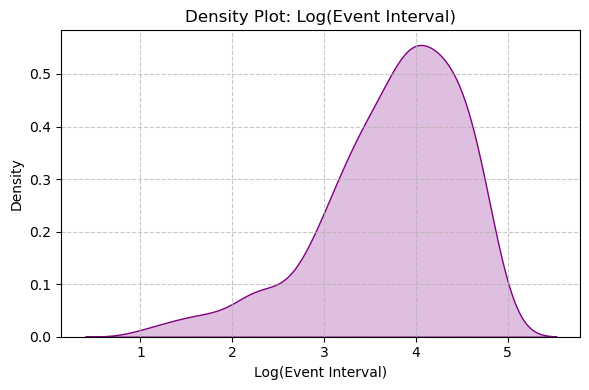

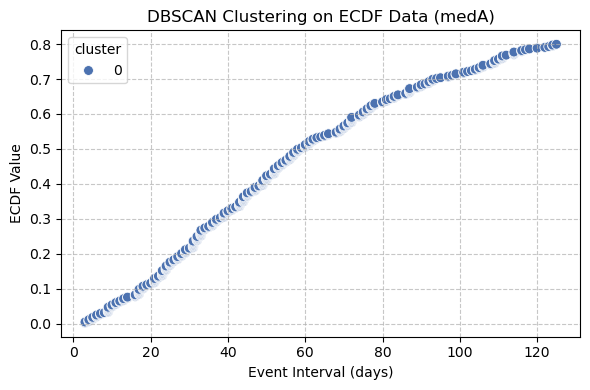

c:\Users\Niles Rondez\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


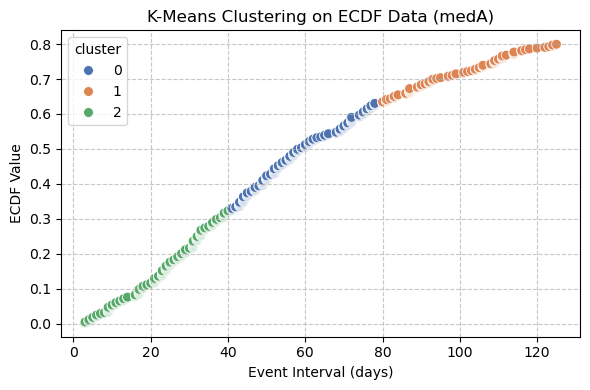


=== Clustering Results for medB ===


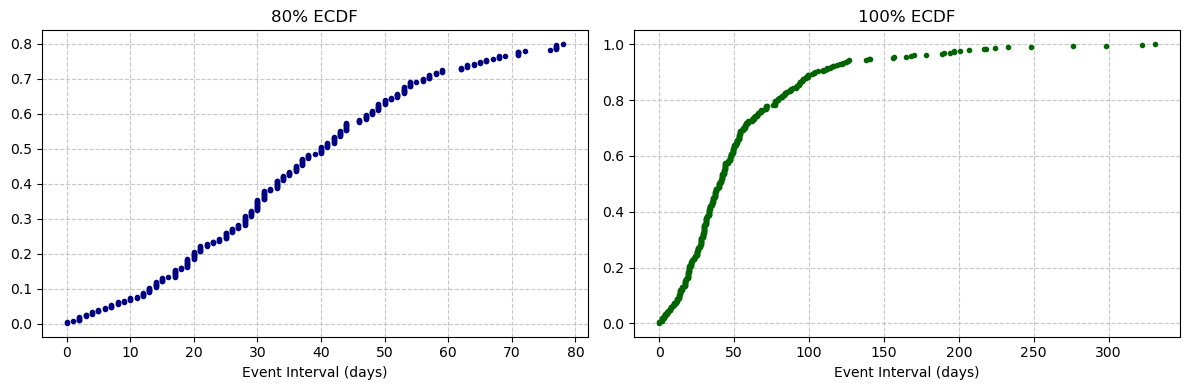

c:\Users\Niles Rondez\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Niles Rondez\AppData\Local\Temp\ipykernel_17612\3643743130.py:65: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.log(dfper['x']), shade=True, color='purple')


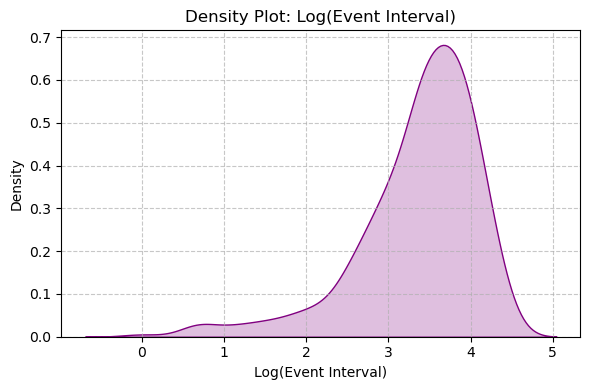

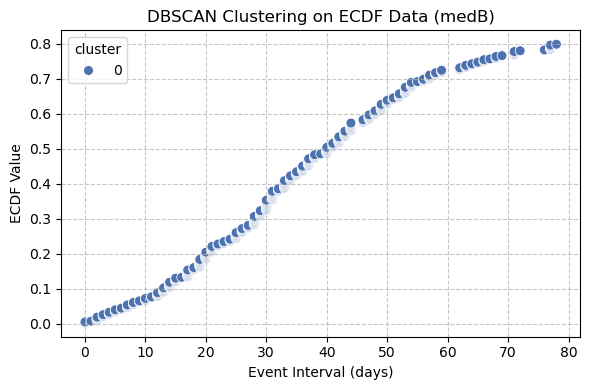

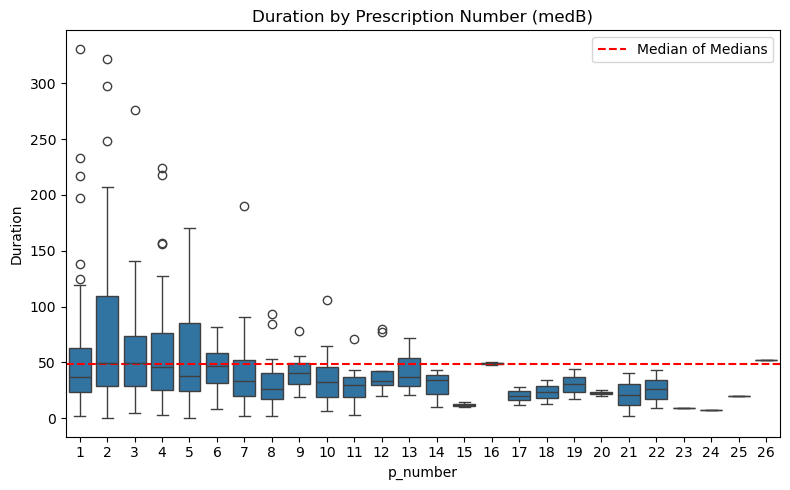

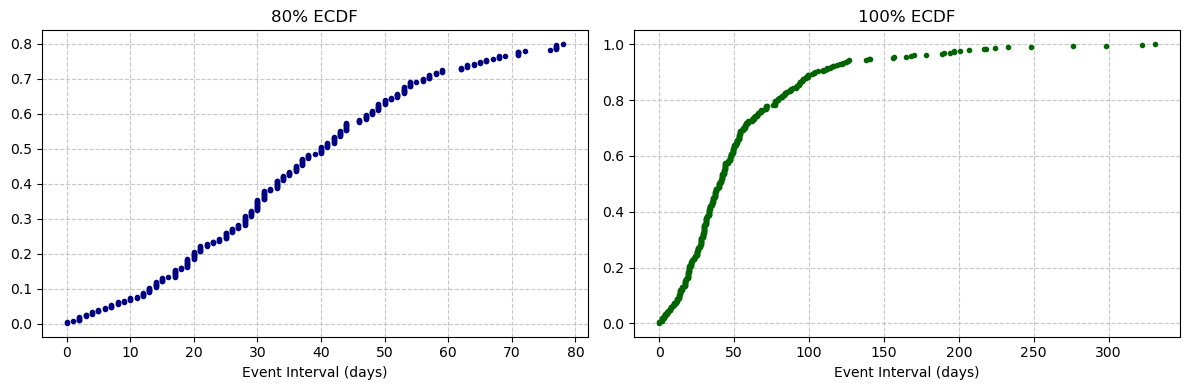

c:\Users\Niles Rondez\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Niles Rondez\AppData\Local\Temp\ipykernel_17612\3643743130.py:65: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.log(dfper['x']), shade=True, color='purple')


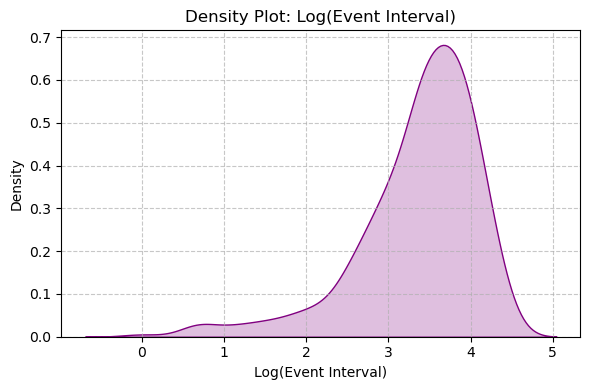

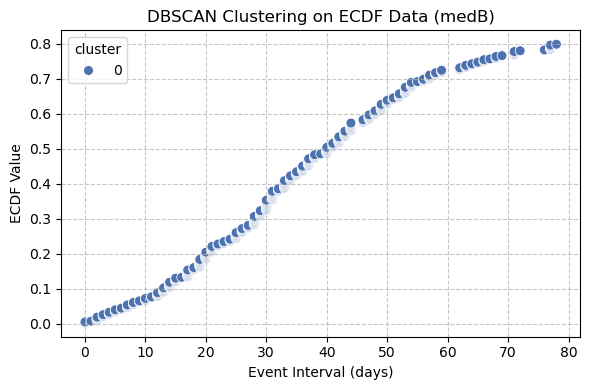

c:\Users\Niles Rondez\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


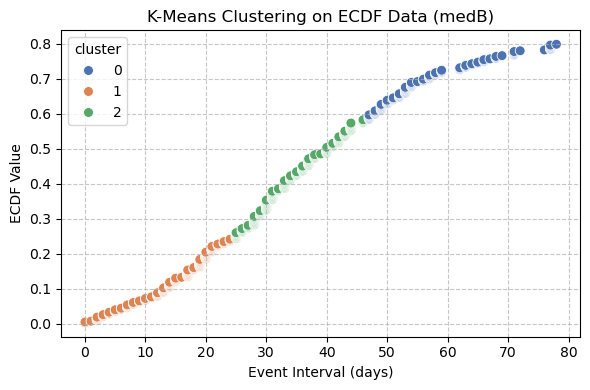

{'data':      PATIENT_ID        DATE  PERDAY CATEGORY  DURATION
 0             1  2033-07-04       4     medB        30
 1             1  2033-08-03       4     medB        30
 2             1  2033-08-17       4     medB        30
 3             1  2033-10-13       4     medB        30
 4             1  2033-10-16       4     medB        30
 ..          ...         ...     ...      ...       ...
 508         100  2034-03-05       6     medB        30
 509         100  2034-04-07       6     medB        30
 510         100  2034-04-26       6     medB        30
 511         100  2034-05-26       6     medB        30
 512         100  2034-07-09       4     medB        30
 
 [513 rows x 5 columns],
 'ecdf_data':       x         y  cluster
 0     0  0.002320        1
 1     0  0.004640        1
 2     1  0.006961        1
 3     2  0.009281        1
 4     2  0.011601        1
 ..   ..       ...      ...
 339  77  0.788863        0
 340  77  0.791183        0
 341  77  0.793503        0


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from datetime import datetime
from IPython.display import display

# ------------------------------
# Load simulated data from med_events.csv
# ------------------------------
file_path = './med_events.csv'
med_events = pd.read_csv(file_path)
med_events['DATE'] = pd.to_datetime(med_events['DATE'], errors='coerce').dt.date

# ------------------------------
# Function: SeeDBSCAN (using DBSCAN Clustering)
# ------------------------------
def SeeDBSCAN(arg1, tidy):
    data_med = tidy[tidy['CATEGORY'] == arg1].copy()
    if data_med.empty:
        raise ValueError(f"No data found for medication {arg1}")
    
    data_med = data_med.sort_values(by=['PATIENT_ID', 'DATE'])
    
    intervals = []
    patient_data_list = []
    for patient_id in data_med['PATIENT_ID'].unique():
        patient_data = data_med[data_med['PATIENT_ID'] == patient_id]
        if len(patient_data) > 1:
            dates = pd.to_datetime(patient_data['DATE'])
            patient_intervals = np.diff(dates).astype('timedelta64[D]').astype(int)
            intervals.extend(patient_intervals)
            patient_data_list.append(patient_data)
            
    if len(intervals) == 0:
        raise ValueError("No intervals found. Each patient must have at least two prescriptions.")
    
    ecdf_x = np.sort(intervals)
    ecdf_y = np.arange(1, len(ecdf_x)+1) / len(ecdf_x)
    dfper = pd.DataFrame({'x': ecdf_x, 'y': ecdf_y})
    dfper = dfper[dfper['y'] <= 0.8]
    if len(dfper) == 0:
        raise ValueError("No data points remain after filtering for 80% ECDF")
    
    # Plot ECDF and density
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(dfper['x'], dfper['y'], marker=".", linestyle="none", color='navy')
    plt.xlabel("Event Interval (days)")
    plt.title("80% ECDF")
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.subplot(1,2,2)
    plt.plot(ecdf_x, ecdf_y, marker=".", linestyle="none", color='darkgreen')
    plt.xlabel("Event Interval (days)")
    plt.title("100% ECDF")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(6,4))
    sns.kdeplot(np.log(dfper['x']), shade=True, color='purple')
    plt.xlabel("Log(Event Interval)")
    plt.title("Density Plot: Log(Event Interval)")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # DBSCAN Clustering
    a = dfper[['x']].copy()
    a = scale(a)
    dbscan = DBSCAN(eps=1.5, min_samples=5)
    dfper['cluster'] = dbscan.fit_predict(a)
    
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=dfper, x='x', y='y', hue='cluster', palette='deep', s=50)
    plt.xlabel("Event Interval (days)")
    plt.ylabel("ECDF Value")
    plt.title(f"DBSCAN Clustering on ECDF Data ({arg1})")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    final_df = pd.concat(patient_data_list, ignore_index=True)
    
    return {'data': final_df, 'ecdf_data': dfper}

# ------------------------------
# Function: SeeKMeans (K-Means Clustering)
# ------------------------------
def SeeKMeans(arg1, tidy, n_clusters=3):
    result = SeeDBSCAN(arg1, tidy)
    dfper = result['ecdf_data']
    
    # K-Means Clustering
    a = dfper[['x']].copy()
    a = scale(a)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    dfper['cluster'] = kmeans.fit_predict(a)
    
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=dfper, x='x', y='y', hue='cluster', palette='deep', s=50)
    plt.xlabel("Event Interval (days)")
    plt.ylabel("ECDF Value")
    plt.title(f"K-Means Clustering on ECDF Data ({arg1})")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return result

# ------------------------------
# Function: see_assumption
# ------------------------------
def see_assumption(result, med_label):
    if not isinstance(result, dict) or 'data' not in result:
        raise TypeError("Expected a dictionary with a 'data' key from See function")
    
    data = result['data']
    data = data.sort_values(by=['PATIENT_ID', 'DATE'])
    data['prev_date'] = data.groupby('PATIENT_ID')['DATE'].shift(1)
    data['Duration'] = data.apply(lambda row: (pd.to_datetime(row['DATE']) - pd.to_datetime(row['prev_date'])).days if pd.notnull(row['prev_date']) else np.nan, axis=1)
    data = data.dropna(subset=['Duration'])
    data['p_number'] = data.groupby('PATIENT_ID').cumcount() + 1
    
    medians_of_medians = data.groupby('PATIENT_ID')['Duration'].median().reset_index()
    
    plt.figure(figsize=(8,5))
    sns.boxplot(x='p_number', y='Duration', data=data)
    plt.axhline(y=medians_of_medians['Duration'].median(), color='r', linestyle='--', label='Median of Medians')
    plt.title(f"Duration by Prescription Number ({med_label})")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return data

# ------------------------------
# Example usage for medA & medB
# ------------------------------
print("=== Clustering Results for medA ===")
medA_result = SeeDBSCAN("medA", med_events)
see_assumption(medA_result, "medA")
SeeKMeans("medA", med_events)

print("\n=== Clustering Results for medB ===")
medB_result = SeeDBSCAN("medB", med_events)
see_assumption(medB_result, "medB")
SeeKMeans("medB", med_events)

### Comparison
K-Means:
- Creates evenly sized clusters but struggles with irregular adherence patterns.
- Assigns all patients to clusters, which may lead to forced classifications.
- Works well for structured datasets but lacks flexibility in handling noise.

DBSCAN: 
- Detects natural groups without requiring a predefined number of clusters.
- Identifies outliers and marks them as noise, improving data accuracy.
- More effective when adherence behaviors do not conform to strict cluster shapes.

### Key Differences
- **Clustering Approach**: K-Means forces every patient into a cluster, while DBSCAN can classify outliers separately.
- **Flexibility**: DBSCAN adapts better to real-world adherence patterns, whereas K-Means assumes predefined cluster shapes.
- **Suitability**: K-Means is better for structured, well-separated data, while DBSCAN is more effective in capturing sporadic medication adherence.

Depending on the dataset and analysis goals, DBSCAN may be the preferred method for real-world medication adherence studies, as it better captures outlier behaviors and irregular adherence patterns.
